在自然语言系统值，单词是基本单位，词向量是用于表示单词的特征向量。将单词映射到实数向量的技术称为单词嵌入。用于表示单词之前使用过one-hot作为处理，但是one-hot有一个缺点就是无法用于体现单词之间的关系。通常使用两个词向量的余弦距离来表示其相似度，使用one-hot表示的词向量之间的预先相似度都为0，故无法表示相似程度。可以使用Word2vec来解决这个问题。它使用固定长度的向量来表示每一个单词，并且这些向量之间可以更好的表示相似性。Word2vec工具包含两个模型：
+ 跳过语法
+ 连续词袋（CBOW）

## 1.Skip-Gram 模型

Skip-Gram模型假设可以使用一个词作为中心，文本序列中的其他词汇围绕这个单词生成。我们假定文本序列为“ the”，“ man”，“ loves”，“ his”和“ son”。我们使用“ loves”作为中心目标词，并将上下文窗口大小设置为2。

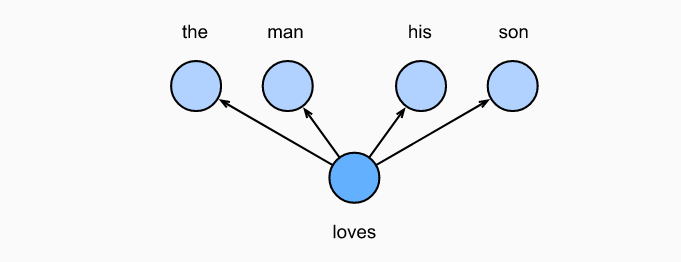

 给定中心词汇 "loves", skip-gram 模型根据距离不超过2个字的上下文词汇 "the", "man", "his" and "son"的条件概率有关：

$$P(\textrm{"the"},\textrm{"man"},\textrm{"his"},\textrm{"son"}\mid\textrm{"loves"}).$$

我们假设,给定中心词汇以后上下文词汇是彼此独立生成的,在这种情况下上面的公式可以改写为：

$$P(\textrm{"the"}\mid\textrm{"loves"})\cdot P(\textrm{"man"}\mid\textrm{"loves"})\cdot P(\textrm{"his"}\mid\textrm{"loves"})\cdot P(\textrm{"son"}\mid\textrm{"loves"}).$$

在 skip-gram 模型中, 每个单词都通过2个 $d$-维向量表示 , 用于计算条件概率。我们假设词在字典里为索引为 $i$，在它为中心词汇的时候它的词向量表示为 $\mathbf{v}_i\in\mathbb{R}^d$ ， 为上下文的时候词向量为 $\mathbf{u}_i\in\mathbb{R}^d$。假设中心词汇 $w_c$ 和上下文词汇 $w_o$ 分别在词典里的索引为 $c$ 和$o$。上下文词汇的条件概率对于中心词汇的条件概率可以通过向量内积运算之后通过softmax运算获得:

$$P(w_o \mid w_c) = \frac{\text{exp}(\mathbf{u}_o^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)},$$

词汇索引为 $\mathcal{V} = \{0, 1, \ldots, |\mathcal{V}|-1\}$.。假设一个给定长度为 $T$ 的文本，时间步 $t$的单词为 $w^{(t)}$。假设上下文词是在给定中心词的情况下独立生成。当上下文窗口为 $m$,  skip-gram 模型的似然函数是在给定中心词的情况下生成所有上下文单词的联合概率：

$$ \prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t)}),$$

时间步大于 1或是小于 $T$ 忽略不计。


## 2. 连续词袋（CBOW）模型

连续词袋（CBOW）模型与Skip-Gram模型相似。最大的不同是CBOW模型假设中心词是根据文本序列中的上下文词汇生成。对于相同的文本序列“ the”，“ man”，“ loves”，“ his”和“ son”，其中“ loves”是中心目标词，给定上下文窗口大小为2，则CBOW模型与根据上下文单词“ the”，“ man”，“ his”和“ son”生成目标单词“ loves”的条件概率。

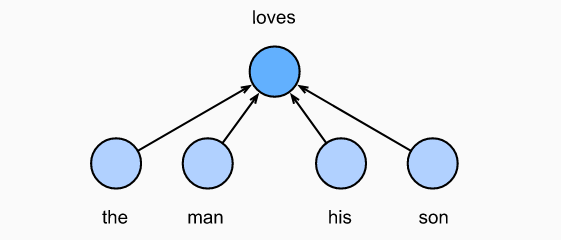


$$P(\textrm{"loves"}\mid\textrm{"the"},\textrm{"man"},\textrm{"his"},\textrm{"son"}).$$


## 3. 近似训练

Skip-Gram模型和CBOW模型最总都是通过softmax获取条件概率。因此每一步的梯度计算都包含字典大小中项数的总和。对于具有数十万甚至数百万个单词的较大词典，计算每个梯度的开销可能太高。为了减少这种计算复杂性，我们将在本节中介绍两种近似训练方法：负采样和分层softmax。

+ 负采样通过考虑包含正例和负例的独立事件来构造损失函数。训练过程中每个步骤的梯度计算开销与我们采样的噪声词的数量呈线性关系。
+ 分层softmax使用二叉树并根据从根节点到叶节点的路径构造损失函数。训练过程中每个步骤的梯度计算开销与字典大小的对数有关。


## 4. word2vec数据集
数据集是[Penn Tree Bank（PTB）](https://catalog.ldc.upenn.edu/LDC99T42)，这是一个很小的但常用的语料库。它从《华尔街日报》的文章中抽取样本，包括培训集，验证集和测试集。

In [15]:
from d2l import mxnet as d2l
from mxnet import np, npx, gluon, init, autograd
import pandas as pd
import os 
import math
import random
from plotly import express as px
npx.set_np()

### 4.1 读取数据集
数据集的每一行都充当一个句子。句子中的所有单词都用空格分隔。在单词嵌入任务中，每个单词都是一个标记。

In [2]:
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',  '319d85e578af0cdc590547f26231e4e31cdf1e42')


def read_ptb():
    data_dir = d2l.download_extract('ptb')
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'sentences number:  {len(sentences)}'

'sentences number:  42069'

创建一个词汇表，将出现频率不大于10的分配为“&lt;UNK&gt;”令牌.预处理PTB数据也包含“&lt;UNK&gt;”令牌呈现罕见词语。

In [3]:
class Vocab:  
    """生成词汇表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 通过出现频率排序
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[0])
        self.token_freqs.sort(key=lambda x: x[1], reverse=True)
        # unknown 的 token 用0标记
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [token for token, freq in self.token_freqs
                        if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

def count_corpus(tokens):
    # 统计token 的频率
    # 如果token是2维列表的话需要转成1维
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return __import__("collections").Counter(tokens)

vocab = Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

### 4.2 二次采样

二次采样试图最大程度地减少高频单词对单词嵌入模型训练的影响。在文本数据中，通常会有一些单词以较高的频率出现，例如英语中的“ the”，“ a”和“ in”。一般来说，在上下文窗口中，当单词(例如“芯片”)和一个低频词汇（例如“微处理器”）同时出现的时候训练模型，而不是和出现频率较高的单词（例如“ the”）同时出现的时候训练模型。因此在训练模型的时候要对单词进行二次采样，目的是将一些高频词汇去掉：

$$ P(w_i) = \max\left(1 - \sqrt{\frac{t}{f(w_i)}}, 0\right),$$

$f(w_i)$ 是单词 $w_i$ 在数据集中的比例, 常数 $t$ 是一个超参数 (这里设置为 $10^{-4}$ )。就像我们看到那样， 当 $f(w_i) > t$时$w_i$将会被删掉。因此单词出现频率越高越容易被删掉。


In [6]:
def subsampling(sentences, vocab):
    # 低频率单词映射到<unk>
    sentences = [[vocab.idx_to_token[vocab[tk]] for tk in line]
                 for line in sentences]
    # 为单词统计频率
    counter = d2l.count_corpus(sentences)
    num_tokens = sum(counter.values())

    # 二次抽样函数
    def keep(token):
        return(random.uniform(0, 1) < math.sqrt(1e-4 / counter[token] * num_tokens))

    # 进行二次抽样
    return [[tk for tk in line if keep(tk)] for line in sentences]

subsampled = subsampling(sentences, vocab)

比较采样前后的序列长度，可以看到子采样显着减少了序列长度。

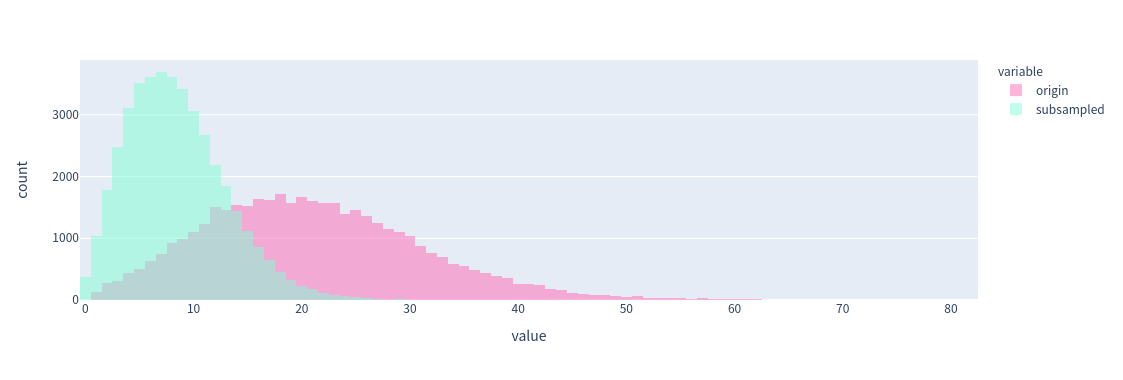

In [34]:
df = pd.DataFrame([[len(line) for line in sentences], [len(line) for line in subsampled]], index=['origin', 'subsampled']).T
fig = px.histogram(df,color_discrete_sequence=[ "hotpink", "aquamarine"], width=600, height=380)
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.5)

高频单词“ the”的采样率降为原来的1/20。而低频的“join”完全被保留了。

In [37]:
def compare_counts(token):
    return (f'# of "{token}": '
            f'before={sum([line.count(token) for line in sentences])}, '
            f'after={sum([line.count(token) for line in subsampled])}')

print(compare_counts('the'))
print(compare_counts('join'))

# of "the": before=50770, after=2070
# of "join": before=45, after=45


最后，我们将每个标记映射到索引用来构建语料库。

In [38]:
corpus = [vocab[line] for line in subsampled]
corpus[0:3]

[[0, 0], [392, 32, 2132, 145, 406], [5464, 3080, 1595]]

## 5. 加载数据集

### 5.1 提取中心词和上下文词

我们使用距中心目标词的距离不超过上下文窗口大小的词作为给定中心目标词的上下文词。以下定义函数提取所有中心目标词及其上下文词。它均匀且随机地采样一个整数，以用作整数1和max_window_size（最大上下文窗口）之间的上下文窗口大小 。

In [39]:
def get_centers_and_contexts(corpus, max_window_size):
    centers, contexts = [], []
    for line in corpus:
        # 每个句子至少需要两个词才能构建中心词-上下文词对
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # 窗口以i为中心
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),  min(len(line), i + 1 + window_size)))
            # 将中心词从上下文词中剔除
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

接下来，我们创建一个包含两个分别由7个单词和3个单词组成的句子的人工数据集。假定最大上下文窗口为2，并打印所有中心目标词及其上下文词。

In [41]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1]
center 1 has contexts [0, 2, 3]
center 2 has contexts [1, 3]
center 3 has contexts [2, 4]
center 4 has contexts [3, 5]
center 5 has contexts [4, 6]
center 6 has contexts [4, 5]
center 7 has contexts [8]
center 8 has contexts [7, 9]
center 9 has contexts [7, 8]


我们将最大上下文窗口大小设置为5。下面将提取数据集中的所有中心目标词及其上下文词。

In [42]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {len(all_centers)}'

'# center-context pairs: 352504'

### 5.2 负采样

我们使用负采样进行近似训练。对于中心词和上下文词对，我们随机抽样 K  杂音词（ K=5  在实验中）。我们首先定义一个类，以根据采样权重绘制候选对象。它缓存10000个大小的随机数存储库，而不是random.choices每次都调用 。0，1，2分别以[2, 3, 4]的权重被抽到

In [45]:
class RandomGenerator:
    def __init__(self, sampling_weights):
        self.population = list(range(len(sampling_weights)))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i-1]

generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[0, 1, 1, 2, 2, 0, 0, 2, 1, 1]

In [46]:
def get_negatives(all_contexts, corpus, K):
    counter = d2l.count_corpus(corpus)
    sampling_weights = [counter[i]**0.75 for i in range(len(counter))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # 干扰词不可以是上下文词
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, corpus, 5)

### 5.3 分批读取

将中心词，上下文词，以及噪声词共同构造数据集：

+ 将上下文词和噪声词连接
+ 由于上下文长短不一将所有的连接长度通过0补齐为max_len，通过mask记录哪些是补齐的值
+ 通过label记录哪些是原来的上下文值
+ 通过label和mask可以判断哪些是噪声

In [47]:
def batchify(data):
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (np.array(centers).reshape(-1, 1), np.array(contexts_negatives), np.array(masks), np.array(labels))

x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = [[1.]
 [1.]]
contexts_negatives = [[2. 2. 3. 3. 3. 3.]
 [2. 2. 2. 3. 3. 0.]]
masks = [[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0.]]
labels = [[1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]]


### 5.4 整合
通过一个函数整合数据获取，并且生成数据迭代器

In [48]:
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled = subsampling(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(corpus, max_window_size)
    all_negatives = get_negatives(all_contexts, corpus, num_noise_words)
    dataset = gluon.data.ArrayDataset(all_centers, all_contexts, all_negatives)
    data_iter = gluon.data.DataLoader(dataset, batch_size, shuffle=True, batchify_fn=batchify,
                                      num_workers=d2l.get_dataloader_workers())
    return data_iter, vocab

让我们打印数据迭代器的第一个小批量。

In [49]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: (512, 1)
contexts_negatives shape: (512, 60)
masks shape: (512, 60)
labels shape: (512, 60)
